In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 
import os

In [2]:
# read the shapefile map for crime records
crime = gpd.read_file("geo_export_9096db6d-c7f3-4196-a658-d825bba6405a.shp")
# delete some points without geographic attributes
crime = crime[crime.geometry.type == 'Point']

In [3]:
# collect the types of the crime
types = []
crime_type = list(crime['parent_inc'])
for i in range(len(crime_type)):
    if i == 0:
        types.append(crime_type[i])
    else:
        if crime_type[i] in types:
            pass
        else:
            types.append(crime_type[i])
tp_sum = [0,0,0,0,0,0,0,0,0]
for j in crime_type:
    for k in range(len(types)):
        if j == types[k]:
            tp_sum[k] = tp_sum[k] + 1
            break

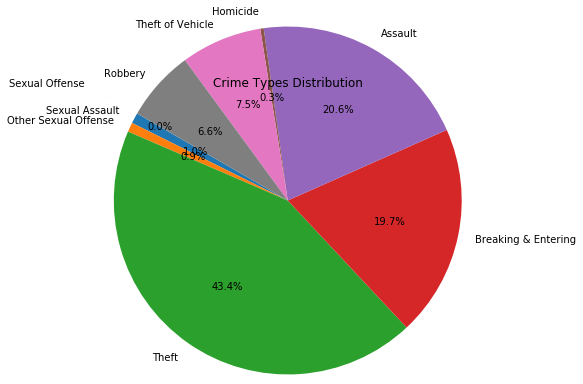

In [4]:
# plot the pie chart for crime types
explode = (0,0,0,0,0,0,0,0,0.5)
plt.pie(tp_sum,explode=explode,labels=types,autopct='%1.1f%%',shadow=False,startangle=150,radius=2)
plt.title('Crime Types Distribution')
plt.show()  

In [5]:
# read the shapefile map for cameras
camera = gpd.read_file("camera.shp")

In [6]:
# read the shapefile map for neighborhoods
neighborhoods = gpd.read_file("Neighborhoods.shp")

In [7]:
# split years from 'date_creat' column
import time
date = crime['date_creat']
year = []

In [8]:
for i in date:
    idate = i.split("-")
    iyear = int(idate[0])
    year.append(iyear)

In [9]:
yearc = list(range(2009,2019))
n = []
for i in range(2009,2019):
    n.append(year.count(i))

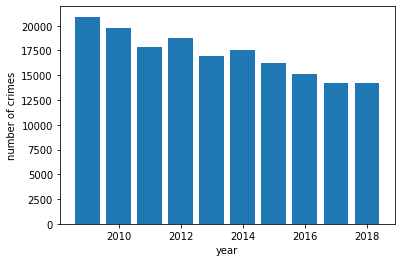

In [10]:
# plot histogram 
# x: year
# y: number of crimes
plt.bar(x=yearc,height=n)
plt.ylabel('number of crimes')
plt.xlabel('year')
plt.show()

[-78.95, -78.75, 42.8, 43]

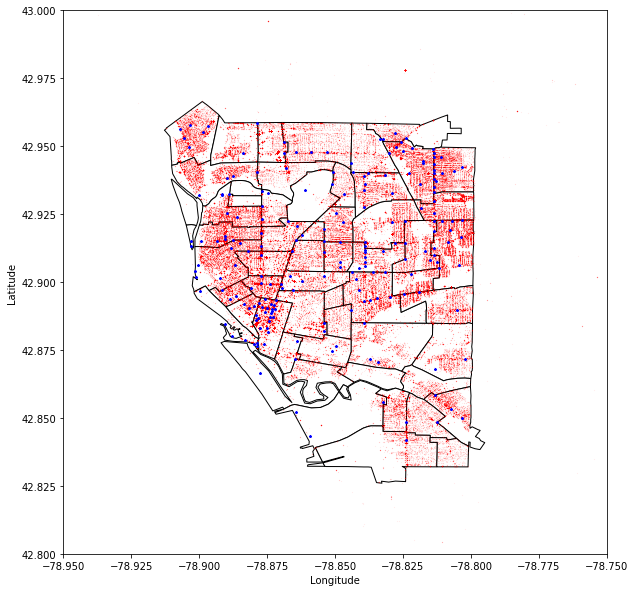

In [11]:
# plot the distribution of crimes(red points) and cameras(blue points) on neighborhoods map
neighborhoods.plot(color='white', edgecolor='black',figsize=(10,10))
plt.scatter(crime['longitude'], crime['latitude'], c="r", s=0.0005)
plt.scatter(camera['x'], camera['y'], c="b", s=5, marker="*")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis([-78.95,-78.75,42.8,43])

In [12]:
# new columns for number of crimes and cameras
# initialized by 0
neighborhoods['n_crime'] = 0
neighborhoods['n_camera'] = 0

In [13]:
# spatial join (neighborhoods,camera)
# count numbers in each neighborhood
dfsjoin = gpd.sjoin(neighborhoods,camera)
a = list(dfsjoin.index.values)

In [14]:
for i in range(len(neighborhoods.n_camera)):
    neighborhoods.loc[i,'n_camera'] = len([x for x in a if x == i])

In [15]:
# spatial join (neighborhoods,crime)
# count numbers in each neighborhood
dfsjoin1 = gpd.sjoin(neighborhoods,crime)
b = list(dfsjoin1.index.values)

In [16]:
for i in range(len(neighborhoods.n_crime)):
    neighborhoods.loc[i,'n_crime'] = len([x for x in b if x == i])

In [17]:
# read the information of neighborhoods from database
conn = sqlite3.connect('Final_proj.db')
c = conn.cursor()

In [18]:
# combine neighborhoods map and neighborhoods_info table by using the name of the neighborhoods as key
neighborhoods_ = neighborhoods[['NEIGHBOR','n_crime','n_camera']]
# select 'Neighborhood','Median.Income','Poverty.Rate','X..High.School.Education','Percent.Living.Alone' columns from the table in hundreds of factors
dic = {'Neighborhood':[],'Median.Income':[],'Poverty.Rate':[],'X..High.School.Education':[],'Percent.Living.Alone':[]}
data = c.execute("SELECT * from Neighbor;")
for i in data:
    dic['Neighborhood'].append(i[0])
    dic['Median.Income'].append(i[1])
    dic['Poverty.Rate'].append(i[2])
    dic['X..High.School.Education'].append(i[3])
    dic['Percent.Living.Alone'].append(i[4])
neighborhoods_info_ = pd.DataFrame(dic)
dataset = pd.merge(neighborhoods_info_,neighborhoods_,left_on='Neighborhood', right_on='NEIGHBOR')

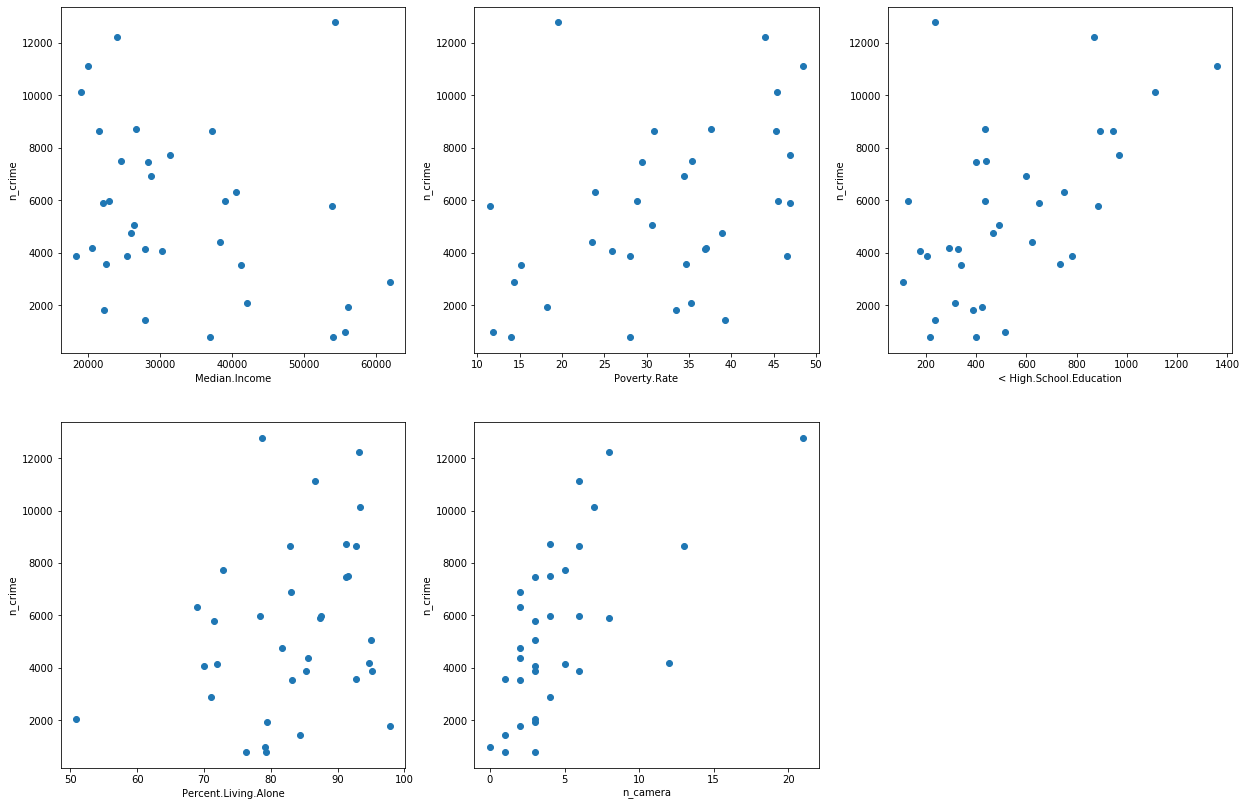

In [19]:
# plot scatters to see the distribution
# x: factors
# y: number of crime
plt.figure(figsize=(21,14))
plt.subplot(231)
plt.scatter(dataset['Median.Income'],dataset['n_crime'])
plt.xlabel('Median.Income')
plt.ylabel('n_crime')
plt.subplot(232)
plt.scatter(dataset['Poverty.Rate'],dataset['n_crime'])
plt.xlabel('Poverty.Rate')
plt.ylabel('n_crime')
plt.subplot(233)
plt.scatter(dataset['X..High.School.Education'],dataset['n_crime'])
plt.xlabel('< High.School.Education')
plt.ylabel('n_crime')
plt.subplot(234)
plt.scatter(dataset['Percent.Living.Alone'],dataset['n_crime'])
plt.xlabel('Percent.Living.Alone')
plt.ylabel('n_crime')
plt.subplot(235)
plt.scatter(dataset['n_camera'],dataset['n_crime'])
plt.xlabel('n_camera')
plt.ylabel('n_crime')
plt.show()

In [20]:
np.set_printoptions(suppress=True)

In [21]:
# correlation coefficient
corr_matrix = dataset.corr()
corr_matrix["n_crime"].sort_values(ascending=False)

n_crime                     1.000000
n_camera                    0.628324
X..High.School.Education    0.543639
Poverty.Rate                0.412051
Percent.Living.Alone        0.269219
Median.Income              -0.292361
Name: n_crime, dtype: float64

In [22]:
# from here we do the same work
# but this time we only use money-related crimes
e_crime = crime.loc[crime.incident_t.isin(['ROBBERY','THEFT OF SERVICES','Breaking & Entering', 'Robbery',
       'Theft of Vehicle'])]

[-78.95, -78.75, 42.8, 43]

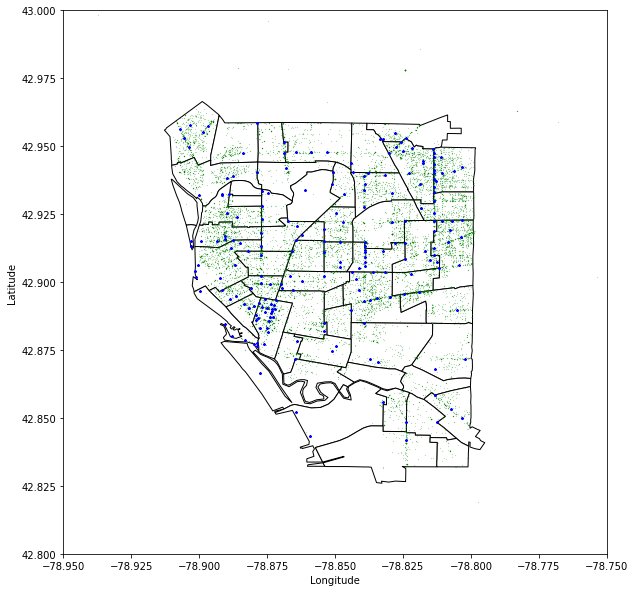

In [23]:
# plot the distribution
neighborhoods.plot(color='white', edgecolor='black',figsize=(10,10))
plt.scatter(e_crime['longitude'], e_crime['latitude'], c="g", s=0.01)
plt.scatter(camera['x'], camera['y'], c="b", s=5, marker="*")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis([-78.95,-78.75,42.8,43])

In [24]:
neighborhoods['n_ecrime'] = 0

In [25]:
# spatial join (neighborhoods,e_crime)
# count numbers in each polygon
dfsjoin2 = gpd.sjoin(neighborhoods,e_crime)
c = list(dfsjoin2.index.values)

In [26]:
for i in range(len(neighborhoods.n_ecrime)):
    neighborhoods.loc[i,'n_ecrime'] = len([x for x in c if x == i])

In [27]:
# first combine neighborhoods1 and neighborhoods_info
neighborhoods1_ = neighborhoods[['NEIGHBOR','n_ecrime','n_camera']]
dataset1 = pd.merge(neighborhoods_info_,neighborhoods1_,left_on='Neighborhood', right_on='NEIGHBOR')

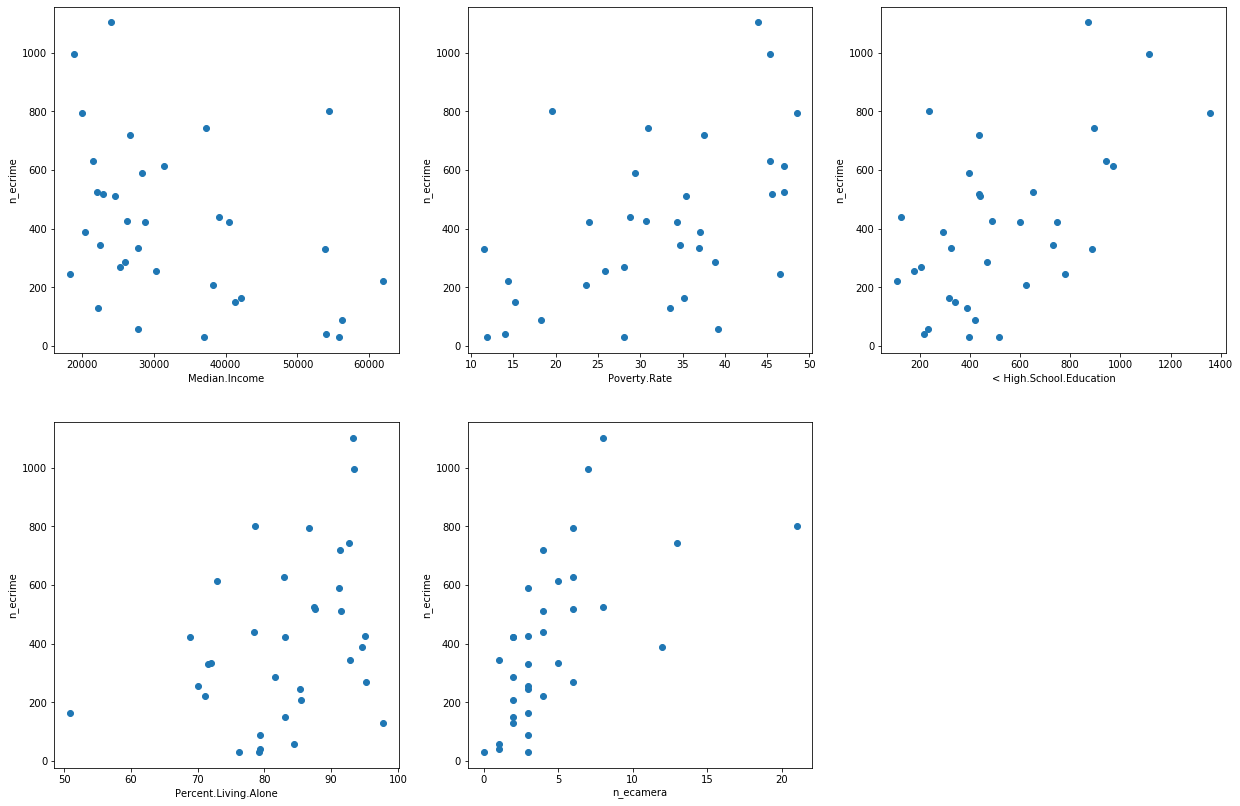

In [28]:
# plot scatter
plt.figure(figsize=(21,14))
plt.subplot(231)
plt.scatter(dataset1['Median.Income'],dataset1['n_ecrime'])
plt.xlabel('Median.Income')
plt.ylabel('n_ecrime')
plt.subplot(232)
plt.scatter(dataset1['Poverty.Rate'],dataset1['n_ecrime'])
plt.xlabel('Poverty.Rate')
plt.ylabel('n_ecrime')
plt.subplot(233)
plt.scatter(dataset1['X..High.School.Education'],dataset1['n_ecrime'])
plt.xlabel('< High.School.Education')
plt.ylabel('n_ecrime')
plt.subplot(234)
plt.scatter(dataset1['Percent.Living.Alone'],dataset1['n_ecrime'])
plt.xlabel('Percent.Living.Alone')
plt.ylabel('n_ecrime')
plt.subplot(235)
plt.scatter(dataset1['n_camera'],dataset1['n_ecrime'])
plt.xlabel('n_ecamera')
plt.ylabel('n_ecrime')
plt.show()

In [29]:
# correlation coefficient
corr_matrix = dataset1.corr()
corr_matrix["n_ecrime"].sort_values(ascending=False)

n_ecrime                    1.000000
n_camera                    0.602122
X..High.School.Education    0.565750
Poverty.Rate                0.517258
Percent.Living.Alone        0.351125
Median.Income              -0.392556
Name: n_ecrime, dtype: float64

In [30]:
try:
    conn.close()
except:
    pass